In [1]:
!pip install pandas numpy matplotlib scikit-learn tabulate transformers torch  gensim nltk plotly


In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 34.9 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate
from transformers import AutoTokenizer, AutoModel
import faiss
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import plotly.express as px

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Data Cleaning and Preprocessing**

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Res.csv to Res.csv
Saving pos.csv to pos.csv


In [5]:
# Utility: Text Cleaning Function
def clean_text(text):
    if isinstance(text, str):
        text = unicodedata.normalize('NFKD', text)  # Normalize text
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
        return text.strip()
    return ''

# Load and Clean Data
def load_and_clean_data(resume_path, job_path):
    resumes_df = pd.read_csv(resume_path)
    postings_df = pd.read_csv(job_path)

    resumes_df['Resume_str'] = resumes_df['Resume_str'].apply(clean_text)
    postings_df['description'] = postings_df['description'].apply(clean_text)

    return resumes_df.dropna(subset=['Resume_str']), postings_df.dropna(subset=['description'])

**Function to Display Results in Tabular Format:**

In [6]:
def display_similarity_results(similarity_matrix, resumes, postings, method_name):

    top_n = 3
    top_matches = np.argsort(-similarity_matrix, axis=1)[:, :top_n]
    results = {
        "Resume_ID": resumes['ID'],
        "Top_Match_1": [postings.iloc[idx]['title'] for idx in top_matches[:, 0]],
        "Top_Match_2": [postings.iloc[idx]['title'] for idx in top_matches[:, 1]],
        "Top_Match_3": [postings.iloc[idx]['title'] for idx in top_matches[:, 2]],
        "Similarity_Scores": [
            [similarity_matrix[row_idx, col_idx] for col_idx in top_matches[row_idx]]
            for row_idx in range(similarity_matrix.shape[0])
        ]
    }

    results_df = pd.DataFrame(results)
    print(f"\n{method_name} Similarity Results:")
    print(tabulate(results_df, headers='keys', tablefmt='pretty'))
    return results_df


**Vectorizing using TF-IDF**

In [7]:
def calculate_tfidf_similarity(resumes, postings):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    resume_vectors = vectorizer.fit_transform(resumes)
    job_vectors = vectorizer.transform(postings)
    similarity_matrix = cosine_similarity(resume_vectors, job_vectors)
    return similarity_matrix

**BERT + FAISS Similarity:**

In [15]:
import torch
def calculate_bert_similarity(resumes, postings):
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    model = AutoModel.from_pretrained('distilbert-base-uncased')

    def get_embeddings(texts):
        tokens = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**tokens)
        return outputs.last_hidden_state.mean(dim=1).numpy()

    resume_embeddings = get_embeddings(resumes)
    job_embeddings = get_embeddings(postings)

    dimension = job_embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    index.add(job_embeddings)
    distances, indices = index.search(resume_embeddings, 3)

    similarity_matrix = np.zeros((len(resumes), len(postings)))
    for i, row in enumerate(indices):
        similarity_matrix[i, row] = distances[i]

    return similarity_matrix


**Jaccard Similarity**

In [9]:
def calculate_jaccard_similarity(resumes, postings):
    resume_terms = [set(text.split()) for text in resumes]
    posting_terms = [set(text.split()) for text in postings]
    similarity_matrix = np.array([
        [
            len(res_set & post_set) / len(res_set | post_set) if len(res_set | post_set) > 0 else 0
            for post_set in posting_terms
        ]
        for res_set in resume_terms
    ])
    return similarity_matrix


**Word2Vec Similarity:**

In [10]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize.punkt import PunktSentenceTokenizer

def calculate_word2vec_similarity(resumes, postings, punkt_path="/root/nltk_data/tokenizers/punkt/english.pickle"):
    """
    Calculate similarity between resumes and job postings using Word2Vec embeddings.

    Parameters:
        resumes (list): List of resume texts.
        postings (list): List of job posting texts.
        punkt_path (str): Path to the punkt tokenizer pickle file.

    Returns:
        similarity_matrix (ndarray): Cosine similarity matrix.
    """
    # Initialize the PunktSentenceTokenizer explicitly
    with open(punkt_path, "rb") as f:
        tokenizer = PunktSentenceTokenizer(f)

    # Tokenize the text into sentences and then split into words
    tokenized_resumes = [[word for sentence in tokenizer.tokenize(resume.lower()) for word in sentence.split()] for resume in resumes]
    tokenized_postings = [[word for sentence in tokenizer.tokenize(posting.lower()) for word in sentence.split()] for posting in postings]

    # Train Word2Vec model
    all_text = tokenized_resumes + tokenized_postings
    model = Word2Vec(sentences=all_text, vector_size=100, window=5, min_count=1, workers=4)

    # Function to get embeddings for a given tokenized text
    def get_embedding(text_tokens):
        vectors = [model.wv[word] for word in text_tokens if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(100)

    # Generate embeddings for resumes and postings
    resume_embeddings = np.array([get_embedding(tokens) for tokens in tokenized_resumes])
    posting_embeddings = np.array([get_embedding(tokens) for tokens in tokenized_postings])

    # Calculate cosine similarity between resumes and postings
    similarity_matrix = cosine_similarity(resume_embeddings, posting_embeddings)
    return similarity_matrix


In [16]:
import pandas as pd
import unicodedata
import re  # Import re module for regular expressions

def clean_text(text):
    if isinstance(text, str):
        text = unicodedata.normalize('NFKD', text)  # Normalize text
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
        return text.strip()

if __name__ == "__main__":
    # File paths
    resumes_path = "/content/Res.csv"
    postings_path = "/content/pos.csv"

    # Load and clean data
    resumes_df, postings_df = load_and_clean_data(resumes_path, postings_path)
    resumes_text = resumes_df['Resume_str'].tolist()
    postings_text = postings_df['description'].tolist()

    # Calculate and display similarities
    tfidf_matrix = calculate_tfidf_similarity(resumes_text, postings_text)
    tfidf_results = display_similarity_results(tfidf_matrix, resumes_df, postings_df, "TF-IDF")

    jaccard_matrix = calculate_jaccard_similarity(resumes_text, postings_text)
    jaccard_results = display_similarity_results(jaccard_matrix, resumes_df, postings_df, "Jaccard")

    bert_matrix = calculate_bert_similarity(resumes_text, postings_text)
    bert_results = display_similarity_results(bert_matrix, resumes_df, postings_df, "BERT + FAISS")

    word2vec_matrix = calculate_word2vec_similarity(resumes_text, postings_text)
    word2vec_results = display_similarity_results(word2vec_matrix, resumes_df, postings_df, "Word2Vec")



TF-IDF Similarity Results:
+----+------------+-----------------------------------------------+-----------------------------------------------+----------------------------------------------------------+------------------------------------------------------------------+
|    | Resume_ID  |                  Top_Match_1                  |                  Top_Match_2                  |                       Top_Match_3                        |                        Similarity_Scores                         |
+----+------------+-----------------------------------------------+-----------------------------------------------+----------------------------------------------------------+------------------------------------------------------------------+
| 0  | 16852973.0 |        Marketing & Office Coordinator         |       Senior Product Marketing Manager        |      Appalachian Highlands Women's Business Center       |  [0.2171467216112787, 0.20518002707678146, 0.16913958317453545]  |
| 1 

**Visualizations**

In [17]:
# Function to extract top terms
def get_top_terms(vector, feature_names, top_n=10):
    vector_sum = np.array(vector.sum(axis=0)).flatten()
    top_indices = vector_sum.argsort()[-top_n:][::-1]
    return [(feature_names[i], vector_sum[i]) for i in top_indices]

# Extract and visualize top terms
def plot_top_terms(vectorizer, vectors, title, top_n=10):
    feature_names = vectorizer.get_feature_names_out()
    top_terms = get_top_terms(vectors, feature_names, top_n=top_n)
    if top_terms:
        words, scores = zip(*top_terms)
        plt.figure(figsize=(10, 6))
        plt.barh(words, scores, color='skyblue')
        plt.xlabel("Frequency")
        plt.title(title)
        plt.gca().invert_yaxis()
        plt.show()
    else:
        print(f"No terms available for visualization in {title}.")


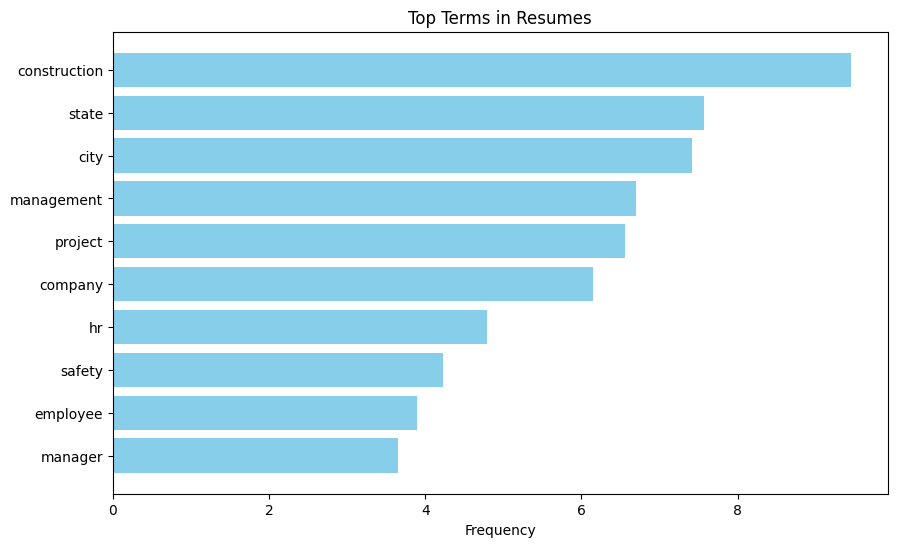

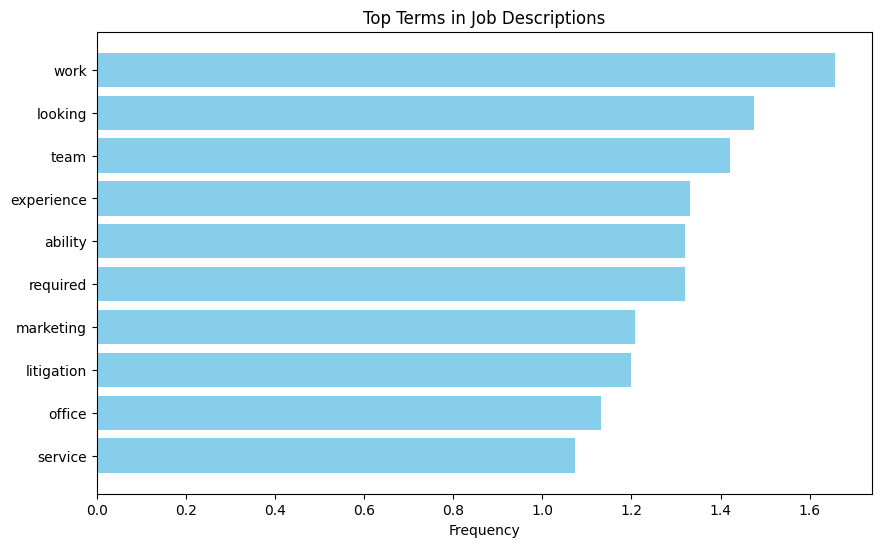

In [18]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import re


def clean_text(text):

    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
        return text
    return ''

# Apply preprocessing to resumes and job descriptions
resumes_df['Resume_str'] = resumes_df['Resume_str'].apply(clean_text)
postings_df['description'] = postings_df['description'].apply(clean_text)

# Combine Text for Unified Vectorization
combined_texts = pd.concat([resumes_df['Resume_str'], postings_df['description']], axis=0)

#  Vectorize Combined Text
vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[a-zA-Z]+\b', max_features=5000)
combined_vectors = vectorizer.fit_transform(combined_texts)

# Split the combined vectors back into resume and posting vectors
resume_vectors = combined_vectors[:len(resumes_df)]
posting_vectors = combined_vectors[len(resumes_df):]

# Extract and Visualize Top Terms
def get_top_terms(vector, feature_names, top_n=10):
    """
    Extract top N terms based on the TF-IDF vector scores.
    """
    vector_sum = vector.sum(axis=0).A1  # Convert sparse matrix to dense array
    top_indices = np.argsort(vector_sum)[-top_n:][::-1]
    return [(feature_names[i], vector_sum[i]) for i in top_indices]

def plot_top_terms(vectorizer, vectors, title, top_n=10):

    feature_names = vectorizer.get_feature_names_out()
    top_terms = get_top_terms(vectors, feature_names, top_n=top_n)
    if top_terms:
        words, scores = zip(*top_terms)
        plt.figure(figsize=(10, 6))
        plt.barh(words, scores, color='skyblue')
        plt.xlabel("Frequency")
        plt.title(title)
        plt.gca().invert_yaxis()
        plt.show()
    else:
        print(f"No terms available for visualization in {title}.")


plot_top_terms(vectorizer, resume_vectors, title="Top Terms in Resumes")
plot_top_terms(vectorizer, posting_vectors, title="Top Terms in Job Descriptions")


**Interactive scatter plots**

In [19]:
import pandas as pd
import plotly.express as px

def plot_interactive_scatter(matches_df, method_name):
    expanded_data = []
    for _, row in matches_df.iterrows():
        for i in range(3):  # Top 3 matches
            expanded_data.append({
                'Resume_ID': row['Resume_ID'],
                'Job_Title': row[f'Top_Match_{i+1}'],
                'Similarity': row['Similarity_Scores'][i]
            })
    expanded_df = pd.DataFrame(expanded_data)

    # Create the interactive scatter plot
    fig = px.scatter(
        expanded_df,
        x="Resume_ID",
        y="Similarity",
        color="Job_Title",
        hover_data=["Job_Title"],
        title=f"Interactive Scatter Plot ({method_name})",
        labels={"Resume_ID": "Resume ID", "Similarity": "Cosine Similarity"},
    )

    # Customize layout
    fig.update_layout(
        title=dict(font=dict(size=20), x=0.5),
        xaxis=dict(title="Resume ID", titlefont=dict(size=14)),
        yaxis=dict(title="Cosine Similarity", titlefont=dict(size=14)),
        legend=dict(title="Job Title", font=dict(size=12)),
        template="plotly_white",  # White background
    )
    fig.show()


In [20]:
plot_interactive_scatter(tfidf_results, "TF-IDF")
plot_interactive_scatter(jaccard_results, "Jaccard")
plot_interactive_scatter(bert_results, "BERT + FAISS")
plot_interactive_scatter(word2vec_results, "Word2Vec")

**Heatmaps**

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_heatmap(matches_df, title):
    matches_df["Average_Similarity"] = matches_df["Similarity_Scores"].apply(np.mean)
    top_3_indices = matches_df.nlargest(3, "Average_Similarity").index
    bottom_2_indices = matches_df.nsmallest(2, "Average_Similarity").index
    selected_indices = top_3_indices.append(bottom_2_indices)
    filtered_matches_df = matches_df.loc[selected_indices]
    similarity_matrix = np.array(filtered_matches_df['Similarity_Scores'].tolist())

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        similarity_matrix,
        cmap="viridis",
        annot=True,
        cbar=True,
        fmt=".3f",
        linewidths=0.5
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Top Matches", fontsize=12)
    plt.ylabel("Selected Resumes", fontsize=12)
    plt.xticks(ticks=np.arange(similarity_matrix.shape[1]) + 0.5, labels=["Top Match 1", "Top Match 2", "Top Match 3"], rotation=45)
    plt.yticks(ticks=np.arange(similarity_matrix.shape[0]) + 0.5, labels=filtered_matches_df['Resume_ID'], rotation=0)
    plt.tight_layout()
    plt.show()


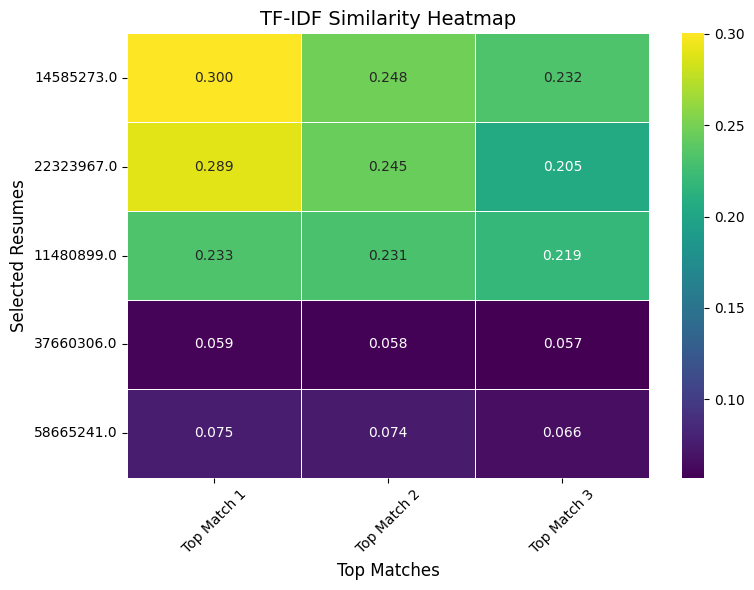

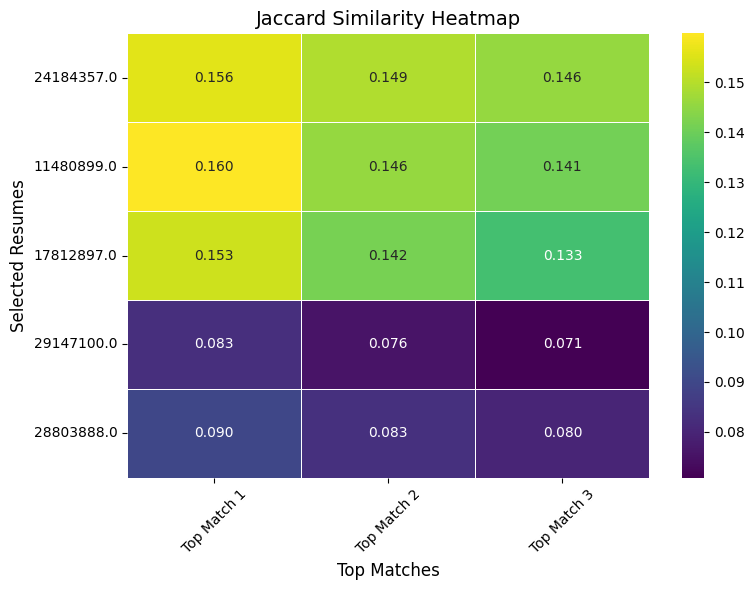

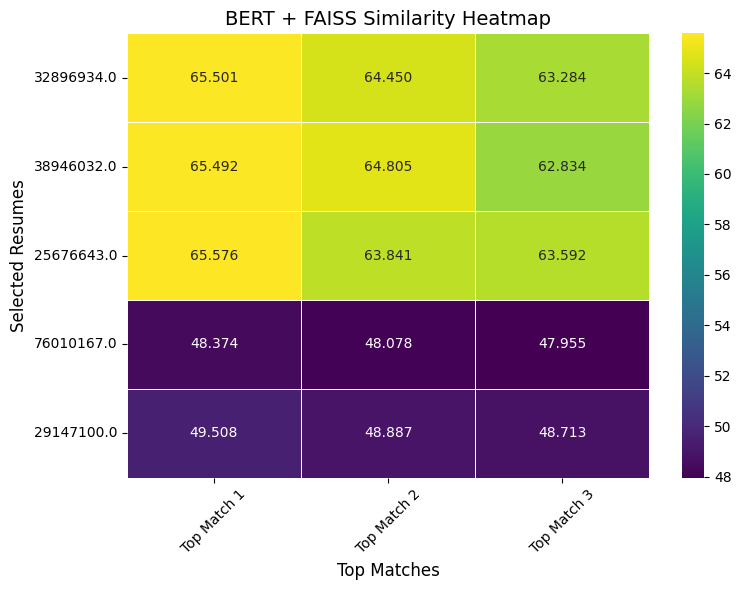

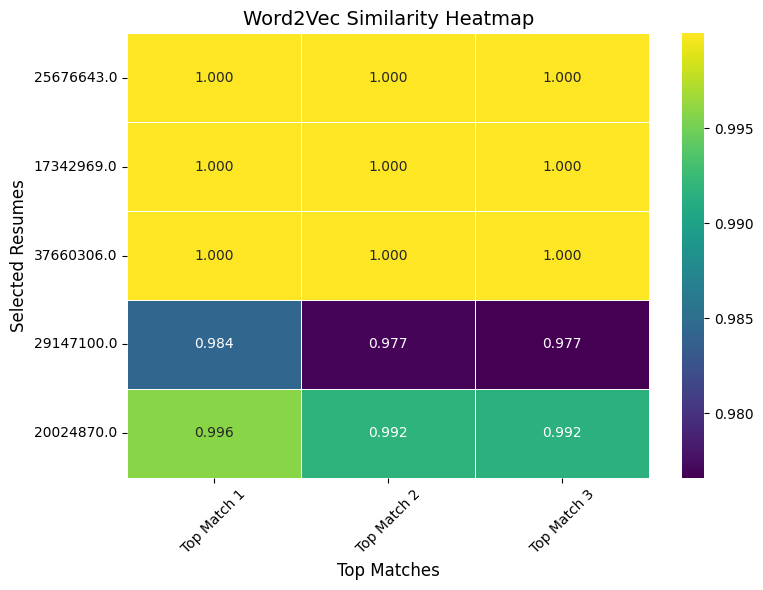

In [22]:
plot_similarity_heatmap(tfidf_results, "TF-IDF Similarity Heatmap")
plot_similarity_heatmap(jaccard_results, "Jaccard Similarity Heatmap")
plot_similarity_heatmap(bert_results, "BERT + FAISS Similarity Heatmap")
plot_similarity_heatmap(word2vec_results, "Word2Vec Similarity Heatmap")

**Display Top 3 Matches for Each Method**

In [23]:
import random
from tabulate import tabulate

def display_top_matches(method_results, method_name, num_resumes=10, random_seed=42):
    """
    Display top 3 matches for a random subset of resumes for a given method.

    Parameters:
        method_results (DataFrame): DataFrame with similarity results for a method.
        method_name (str): Name of the similarity method.
        num_resumes (int): Number of resumes to display.
        random_seed (int): Seed for random selection to ensure consistency.
    """
    print(f"\nTop 3 Matches ({method_name}):")
    # Set random seed for consistency
    random.seed(random_seed)
    # Select random indices
    random_indices = random.sample(range(len(method_results)), min(num_resumes, len(method_results)))
    selected_results = method_results.iloc[random_indices]
    print(tabulate(selected_results, headers='keys', tablefmt='pretty'))
    return selected_results.index  # Return the indices of selected resumes for consistency


In [24]:
display_top_matches(tfidf_results, "TF-IDF")
display_top_matches(jaccard_results, "Jaccard")
display_top_matches(bert_results, "BERT + FAISS")
display_top_matches(word2vec_results, "Word2Vec")


Top 3 Matches (TF-IDF):
+----+------------+-----------------------------------------------+-----------------------------------------------+----------------------------------------------------------+-----------------------------------------------------------------+---------------------+
|    | Resume_ID  |                  Top_Match_1                  |                  Top_Match_2                  |                       Top_Match_3                        |                        Similarity_Scores                        | Average_Similarity  |
+----+------------+-----------------------------------------------+-----------------------------------------------+----------------------------------------------------------+-----------------------------------------------------------------+---------------------+
| 83 | 21567392.0 |       Service / Construction Technician       |               Project Architect               |                 Administrative Assistant                 | [0.17818238

Index([83, 14, 3, 96, 35, 31, 28, 17, 13, 88], dtype='int64')